## LSTM 사용 Text 분류 모델 구현
: Keras의 Embedding,LSTM,Dropout 계층 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

###  Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)
print(df['v2'][0], df['v1'][0])
df.head(20)

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 불필요한 컬럼 삭제

In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.head(20)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### 분포를 시각화

Text(0, 0.5, 'Number of ham and spam messages')

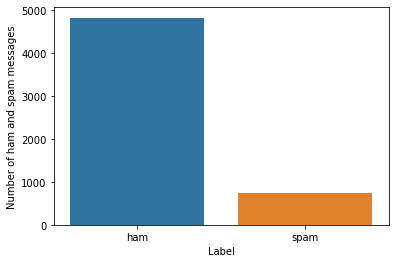

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.ylabel('Number of ham and spam messages')

### Y 값을 0, 1로 변환 : LabelEncoder()

In [6]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)  # Y 값이 0(ham), 1(spam)로 변환, Logistic Regression, sigmoid사용
Y = Y.reshape(-1,1)
Y.shape  # (5572, 1)

(5572, 1)

In [7]:
### train 과 test 데이터 셋으로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)  # 70%:30%
print(X_train.shape, X_test.shape,Y_train.shape,Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

In [9]:
# 토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

max_words = 1000  # D, input_dim
max_len = 150     # T, sequence_length, 한 문장의 길이, 데이터 셋의 길이

tok = Tokenizer(num_words=max_words) # 가장 빈도가 높은 1000개의 단어들만 사용하여 토큰화

# 단어 인덱스를 구축
tok.fit_on_texts(X_train)  # 인덱스 범위 : 0 ~ 999

# 문자열을 정수 인덱스의 리스트로 변환
sequences = tok.texts_to_sequences(X_train) # type은 list
sequences[:4]      # 길이가 서로 다름

# 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) # 신경망에 입력할 X값이다
print(sequences_matrix.shape)  # (3900, 150), 2차원 행렬
word_to_index = tok.word_index
# print(word_to_index)

vocab_size = len(word_to_index)
print(vocab_size)

sequences_matrix

(3900, 150)
7367


array([[  0,   0,   0, ...,  48,   5, 276],
       [  0,   0,   0, ...,   3,   2,  13],
       [  0,   0,   0, ..., 230, 138,   9],
       ...,
       [  0,   0,   0, ..., 196,   8, 685],
       [  0,   0,   0, ..., 141, 137,  92],
       [  0,   0,   0, ...,  46, 665,  50]])

## RNN 신경망 모델 구현

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim : input_dim   , V  , max_words : 1000
# output_dim : hidden_size , D , 50
# input_length : sequence_length , T : max_len:150

In [11]:
# LSTM 1층을 사용하여 신경망을 구현
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words,50,input_length=max_len), # X:(?,150) W:(1000,50)=(?,150,50)
    tf.keras.layers.LSTM(32,return_sequences=True),  # (?,150,50) , W:(50,32) --> (?,150,32)
    tf.keras.layers.Dense(32,activation='relu'),     # (?,150,32) , W: (32,32)  --> (?,150,32)
    tf.keras.layers.Dropout(rate=0.5),                       # (?,150,32)
    tf.keras.layers.Flatten(),                       # (?,150*32) --> (?,4800)
    tf.keras.layers.Dense(1,activation='sigmoid')    # (?,4800), W:(4800,1) -->(?,1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 150, 32)           10624     
_________________________________________________________________
dense (Dense)                (None, 150, 32)           1056      
_________________________________________________________________
dropout (Dropout)            (None, 150, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4801      
Total params: 66,481
Trainable params: 66,481
Non-trainable params: 0
____________________________________________________

In [12]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

In [13]:
# 학습
model.fit(sequences_matrix,Y_train,batch_size=128, epochs=10, validation_split=0.2)

Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 10s 3ms/sample - loss: 0.4122 - accuracy: 0.8449 - val_loss: 0.3320 - val_accuracy: 0.8744
Epoch 2/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.2256 - accuracy: 0.9061 - val_loss: 0.1209 - val_accuracy: 0.9667
Epoch 3/10
3120/3120 [==============================] - 6s 2ms/sample - loss: 0.0902 - accuracy: 0.9721 - val_loss: 0.0708 - val_accuracy: 0.9833
Epoch 4/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.0578 - accuracy: 0.9830 - val_loss: 0.0554 - val_accuracy: 0.9859
Epoch 5/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.0468 - accuracy: 0.9862 - val_loss: 0.0569 - val_accuracy: 0.9859
Epoch 6/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.0361 - accuracy: 0.9904 - val_loss: 0.0583 - val_accuracy: 0.9846
Epoch 7/10
3120/3120 [==============================] - 5s 1ms/sample - loss

### 정확도 측정

In [14]:
#  Test 데이터셋의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환
test_sequences = tok.texts_to_sequences(X_test) 

# 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(test_sequences_matrix.shape,Y_test.shape)  # (1672, 150), 2차원 행렬

(1672, 150) (1672, 1)


In [15]:
# 정확도
accr = model.evaluate(test_sequences_matrix,Y_test)

1672/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [16]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.075
  Accuracy: 0.983


In [17]:
# 예측
preds = model.predict(test_sequences_matrix[1].reshape(1,-1)) # test_sequences_matrix[1]은 1차원이므로
preds,Y_test[1]

(array([[0.99996793]], dtype=float32), array([1]))

In [18]:
test_sequences_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 192, 330, 124,  35,  14, 666,  82,  74,
       607,   2,  22, 115, 167, 300, 262])

In [19]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) 
preds,Y_test[17]

(array([[0.00043936]], dtype=float32), array([0]))

In [28]:
ones = np.where(Y_test==1)  # 답이 1인 인덱스
ones[0]

array([   0,    1,    2,   12,   22,   29,   36,   47,   54,   73,   82,
         83,   89,  102,  112,  114,  115,  116,  117,  122,  141,  147,
        156,  164,  169,  170,  171,  179,  202,  206,  209,  210,  231,
        234,  237,  246,  252,  256,  269,  279,  288,  289,  297,  299,
        302,  303,  314,  323,  325,  336,  338,  365,  367,  370,  378,
        403,  404,  408,  423,  439,  449,  453,  474,  478,  493,  495,
        496,  501,  506,  516,  527,  534,  537,  556,  561,  579,  582,
        585,  586,  587,  593,  615,  620,  627,  628,  633,  640,  653,
        663,  670,  672,  683,  698,  700,  718,  720,  721,  727,  732,
        748,  749,  750,  752,  753,  760,  764,  766,  773,  775,  777,
        786,  819,  820,  828,  833,  847,  860,  866,  877,  881,  900,
        905,  911,  912,  922,  926,  929,  936,  937,  953,  959,  976,
        978,  986, 1010, 1032, 1037, 1049, 1050, 1055, 1060, 1064, 1073,
       1100, 1111, 1118, 1121, 1123, 1137, 1150, 11

In [23]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,Y_test[one])

[[0.9541601]] [1]
[[0.99996793]] [1]
[[0.9999999]] [1]
[[0.9997558]] [1]
[[0.99999964]] [1]
[[0.99999905]] [1]
[[1.]] [1]
[[0.14292936]] [1]
[[0.9999995]] [1]
[[1.]] [1]
[[0.99999964]] [1]
[[0.99999976]] [1]
[[0.9999907]] [1]
[[0.9999987]] [1]
[[0.9999982]] [1]
[[0.99996245]] [1]
[[0.0497096]] [1]
[[0.99999416]] [1]
[[0.00032576]] [1]
[[0.9999516]] [1]
[[0.9999995]] [1]
[[0.9999999]] [1]
[[0.9769448]] [1]
[[0.99992454]] [1]
[[0.99998236]] [1]
[[0.9999045]] [1]
[[0.9961373]] [1]
[[0.99999535]] [1]
[[0.9485208]] [1]
[[0.99999607]] [1]
[[1.]] [1]
[[0.9999999]] [1]
[[0.9999962]] [1]
[[0.99984384]] [1]
[[0.9684488]] [1]
[[0.10913521]] [1]
[[0.99999046]] [1]
[[0.99992585]] [1]
[[0.9999566]] [1]
[[0.99999666]] [1]
[[0.9980038]] [1]
[[1.733705e-05]] [1]
[[0.9999982]] [1]
[[0.9999976]] [1]
[[0.99999976]] [1]
[[0.9997609]] [1]
[[0.9999962]] [1]
[[0.09292067]] [1]
[[0.99697614]] [1]
[[0.9999993]] [1]
[[0.9999994]] [1]
[[0.999987]] [1]
[[0.9999999]] [1]
[[1.]] [1]
[[0.9999927]] [1]
[[0.99835783]] 